## Module 2.4: Working with Auto-Encoders in Keras (A Review)

We implementing a denoising auto-encoder in the Keras functional API. In this module we will pay attention to:

1. Using the Keras functional API for defining models.
2. Understanding denoising auto-encoders.

A denoising auto-encoder is at base just a normal MLP with an unusual use. So this will be a relatively simple tutorial.

Those students who are comfortable with all these matters might consider skipping ahead.

Note that we will not spend time tuning hyper-parameters: The purpose is to show how different techniques can be implemented in Keras, not to solve particular data science problems as optimally as possible. Obviously, most techniques include hyper-parameters that need to be tuned for optimal performance.

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Apr 21 07:19:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

First we import required libraries.

In [100]:
import numpy as np

from keras.datasets import mnist,cifar10
from keras.backend import int_shape
from keras.models import Sequential
from keras import Model
from keras.layers import Dense,Dropout,Flatten,Activation,Input,Reshape, Conv2DTranspose
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

import matplotlib.pyplot as plt


We load the MNIST data. These are 28 by 28 greyscale images of handwritten digits (0-9).

We are going to want few versions of the images:
 - Normalized
 - Normalized + Noise

Of course we also want the image labels, and we will also make use of a vector of class names. Below we give a function that will get these things, the data components divided into training and test sets. We will then call the function.

In [117]:
def get_data(dataset,channels):
  (x_train_raw, y_train), (x_test_raw, y_test) = dataset.load_data()

  # Pre-process them into real numbers between 0 and 1 and flatten
  x_train_raw = x_train_raw.astype('float32') / 255.
  x_test_raw = x_test_raw.astype('float32') / 255.

  # Reshape to channel last (single channel, since greyscale)
  x_train = np.reshape(x_train_raw, (-1, x_train_raw.shape[1], x_train_raw.shape[2], channels))
  x_test = np.reshape(x_train_raw, (-1, x_test_raw.shape[1], x_test_raw.shape[2], channels))

  # Make noisy images by adding Gaussian noise with mean=0.5 and std=0.5
  # noise = np.random.random(size=x_train.shape)
  # noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
  noise = 0
  x_train_noisy = x_train + noise
  # noise = np.random.random(size=x_test.shape)
  # noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
  
  x_test_noisy = x_test + noise
  # But clip values so they remain with 0 and 1
  x_train_noisy = np.clip(x_train_noisy, 0., 1.)
  x_test_noisy = np.clip(x_test_noisy, 0., 1.)

  # class_names=np.array(["0","1","2","3","4","5","6","7","8","9"])
  
  return x_train,x_train_noisy,y_train,x_test,x_test_noisy,y_test

In [54]:
np.random.random(size=x_train.shape).shape

(60000, 28, 28, 1)

In [118]:
#mnist
# class_names=np.array(["0","1","2","3","4","5","6","7","8","9"])
# x_train,x_train_noisy,y_train,x_test,x_test_noisy,y_test=get_data(mnist,1)

#cifar10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
x_train,x_train_noisy,y_train,x_test,x_test_noisy,y_test=get_data(cifar10,3)


Let's create a function that will let us look at the MNIST images, and then call it.

In [119]:
def show_images(images,labels,class_names,shape):
  plt.figure(figsize=(10,10))
  indices=np.random.randint(0,images.shape[0],25)
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[indices[i]].reshape(shape,))
      plt.xlabel(class_names[int(labels[indices[i]])])
  plt.show()

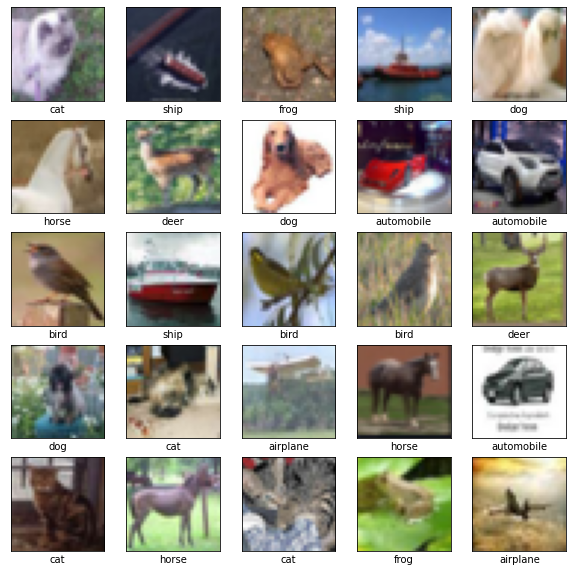

In [121]:
show_images(x_train,y_train,class_names,(32,32,3))

Now the interesting part: It is time to define our Denoising Autoencoder.

It will consist of a number of convolution layers leading to a (flat) vector encoding of the image. We will then seek to reconstruct an image from this vector encoding by passing through a number of transposed (reversed) convolution layers. The idea is that we will encode the important information of a noisy image in the encoding, from which we will reconstruct a denoised version.

We will see when we look at variational autoencoders later that it can be useful to be able to use the encoder and decoder components of some autoencoders as separate models. To that end, we will practice using the Keras functional API to construct several models from the same set of layers. 

In [188]:
def get_models():
  # First define the Encoder Model
  encoder_inputs = Input(shape=(32,32,3), name='Encoder_Input')

  conv1 = Conv2D(filters=32,
                 kernel_size=(3,3),
                 strides=2,
                 activation='relu',
                 padding='same')(encoder_inputs)
  conv2 = Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=2,
                 activation='relu',
                 padding='same')(conv1)
  conv3 = Conv2D(filters=128,
                 kernel_size=(3,3),
                 strides=2,
                 activation='relu',
                 padding='same')(conv2)                 
  flat1 = Flatten()(conv3)
  encoding = Dense(256, name='Encoding')(flat1)

  # Create Encoder Model
  encoder = Model(encoder_inputs, encoding)

  # Now define the Decoder Model
  decoder_inputs = Input(shape=(256,), name='Decoder_Input')

  # We reverse the convolutions.
  # To do this we need to know the shape. We could hard code 
  # this here, but generally we wouldn't want to.
  shape = int_shape(conv3)
  dense2 = Dense(shape[1] * shape[2] * shape[3])(decoder_inputs)
  reshaped = Reshape((shape[1], shape[2], shape[3]))(dense2)

  # We use Transposed Conv2D layers to undo the convolutions
  tconv0 = Conv2DTranspose(filters=128,
                          kernel_size=(3,3),
                          strides=2,
                          activation='relu',
                          padding='same')(reshaped)  
  tconv1 = Conv2DTranspose(filters=64,
                          kernel_size=(3,3),
                          strides=2,
                          activation='relu',
                          padding='same')(tconv0)
  tconv2 = Conv2DTranspose(filters=32,
                          kernel_size=(3,3),
                          strides=2,
                          activation='relu',
                          padding='same')(tconv1)
  # Our final Transposed Conv2D has only one filter:
  # We are recreating the image matrix (almost)
  tconv3 = Conv2DTranspose(filters=3,
                          kernel_size=(3,3),
                          padding='same')(tconv2)
  # We pass this final matrix through a sigmoid and are done
  decoder_outputs = Activation('sigmoid', name='Decoder_Output')(tconv3)

  # Instantiate Decoder Model
  decoder = Model(decoder_inputs, decoder_outputs)

  # Create the Autoencoder Model
  # This takes as input the encoder input
  # And as output the decoder processing of the encoder output
  autoencoder = Model(encoder_inputs, decoder(encoder(encoder_inputs)))

  return encoder,decoder,autoencoder

Let's get our models.

In [189]:
encoder,decoder,autoencoder=get_models()

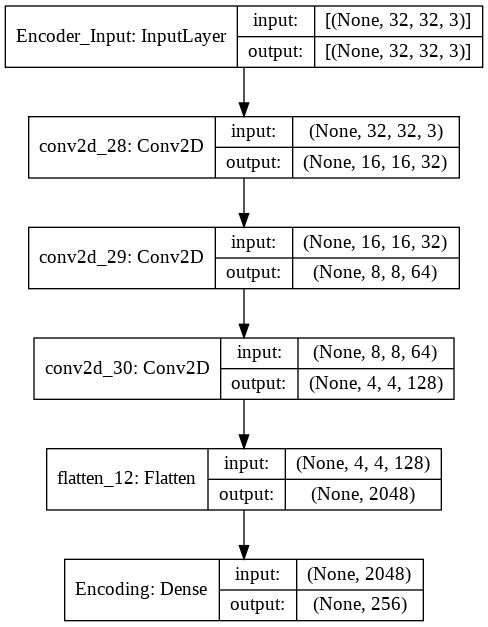

In [190]:
plot_model(encoder, show_shapes=True)

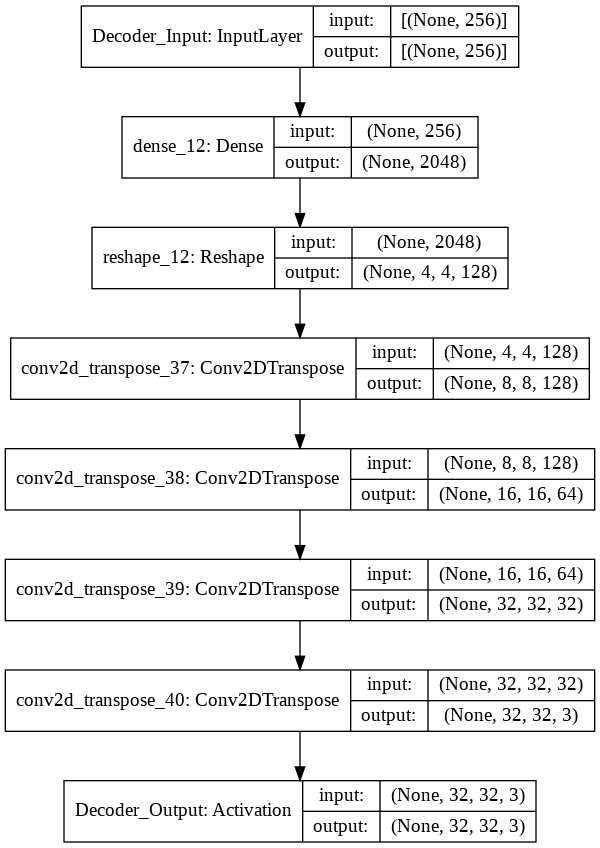

In [191]:
plot_model(decoder, show_shapes=True)

We will be training and using the autoencoder model. So we need to compile it with a chosen optimizer. 

In [192]:
autoencoder.compile(loss='mse', optimizer='adam')

Now we can train our autoencoder. We will use the test data as validation data.

In [194]:
earlyStop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,restore_best_weights=True)

In [195]:
# Train the autoencoder
# Note the target (Y) variables are just the original images
# and the input (X) variables are the noisy equivalents.
history=autoencoder.fit(x_train_noisy,
                        x_train,
                        validation_data=(x_test_noisy, x_test),
                        epochs=100,
                        batch_size=1000,
                        callbacks=earlyStop)

Epoch 1/100
50/50 [==============================] - 6s 105ms/step - loss: 0.0586 - val_loss: 0.0274
Epoch 2/100
50/50 [==============================] - 4s 87ms/step - loss: 0.0243 - val_loss: 0.0187
Epoch 3/100
50/50 [==============================] - 4s 87ms/step - loss: 0.0180 - val_loss: 0.0151
Epoch 4/100
50/50 [==============================] - 4s 87ms/step - loss: 0.0147 - val_loss: 0.0121
Epoch 5/100
50/50 [==============================] - 4s 87ms/step - loss: 0.0125 - val_loss: 0.0109
Epoch 6/100
50/50 [==============================] - 4s 87ms/step - loss: 0.0110 - val_loss: 0.0101
Epoch 7/100
50/50 [==============================] - 4s 88ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 8/100
50/50 [==============================] - 4s 87ms/step - loss: 0.0099 - val_loss: 0.0090
Epoch 9/100
50/50 [==============================] - 4s 88ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 10/100
50/50 [==============================] - 4s 87ms/step - loss: 0.0085 - val_loss: 0.008

You can graph the training history here is you like. It is left as an exercise.

In [134]:
# Graph the training history if desired

def plot_training_history(history):
    # plt.plot(history.history['acc'])
    # plt.plot(history.history['val_acc'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model accuracy and loss')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy','Validation Accuracy', 'Loss',
                'Validation Loss'], loc='upper right')
    plt.show()

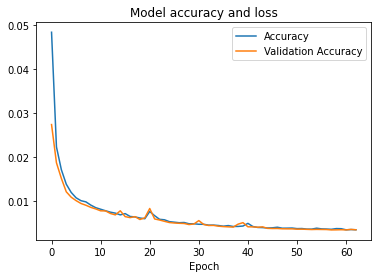

In [196]:
plot_training_history(history)

Now we have a trained denoising autoencoder model, what can we do with it?

We can denoise noisy data of this type - useful in the real world if data is sometimes noisy or corrupted. In our case we can denoise noisy handwritten digits. Let's have a look at an example. First we will create a (quick and rough) function to show the noisy image and compare it with the denoised version.

In [142]:
def denoiser_example(model,noisy_image,true_image):
  denoised_image = model.predict(np.expand_dims(noisy_image, axis=0))
  #plt.figure(figsize=(10,10))
  plt.imshow(np.reshape(noisy_image,(32,32,3)))
  plt.xlabel("Original Image")
  plt.show()
  plt.imshow(np.reshape(denoised_image,(32,32,3)))
  plt.xlabel("Reconstructed Image")
  plt.show()
  # plt.imshow(np.reshape(true_image,(32,32,3)))
  # plt.xlabel("True Image")
  plt.show()
  

Now we can call that function with a random image from the test/validation data.

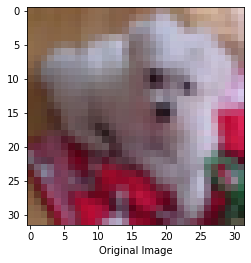

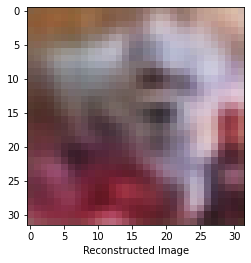

In [205]:
indect = np.random.randint(0,len(x_test_noisy))
denoiser_example(autoencoder,x_test_noisy[indect],x_test[indect])

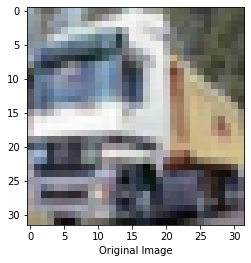

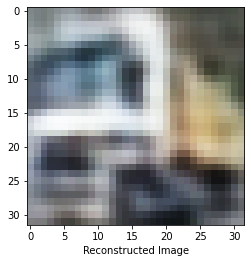

In [197]:
denoiser_example(autoencoder,x_test_noisy[1],x_test[1])